In [7]:
!pip -q install snscrape emoji wordcloud nltk gpt-2-simple

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [71]:
#downloading 10000 tweets from @elonmusk
!snscrape --jsonl --max-results 10000 twitter-search "from:elonmusk" > tweets.json

In [8]:
#data preprocessing libraries
import pandas as pd
import numpy as np
import re
import emoji

#visualization libaries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#corpus analysis libraries
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#gpt2 library
import gpt_2_simple as gpt2

In [9]:
#reading the json file that has the tweets
df = pd.read_json('tweets.json', lines=True)

In [51]:
df.head()

,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags
0,snscrape.modules.twitter.Tweet,https://twitter.com/elonmusk/status/1505058886...,2022-03-19 05:49:35+00:00,Also the heaviest Falcon 9 payload at 16.25 me...,Also the heaviest Falcon 9 payload at 16.25 me...,1505058886130311169,"{'_type': 'snscrape.modules.twitter.User', 'us...",1953,1654,41340,...,None,NaN,None,1.505059e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",None,NaN,NaN,None,NaN
1,snscrape.modules.twitter.Tweet,https://twitter.com/elonmusk/status/1505022792...,2022-03-19 03:26:10+00:00,As it ends the cycle of retribution,As it ends the cycle of retribution,1505022792554663944,"{'_type': 'snscrape.modules.twitter.User', 'us...",3067,3383,69512,...,None,NaN,None,1.505022e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",None,NaN,NaN,None,NaN
2,snscrape.modules.twitter.Tweet,https://twitter.com/elonmusk/status/1505022319...,2022-03-19 03:24:17+00:00,The limbic instinct for vengeance is incredibl...,The limbic instinct for vengeance is incredibl...,1505022319915421696,"{'_type': 'snscrape.modules.twitter.User', 'us...",8364,12951,141414,...,None,NaN,None,NaN,None,None,NaN,NaN,None,NaN
3,snscrape.modules.twitter.Tweet,https://twitter.com/elonmusk/status/1504952756...,2022-03-18 22:47:52+00:00,@mgsiegler Absolutely,Absolutely,1504952756288864256,"{'_type': 'snscrape.modules.twitter.User', 'us...",554,305,11694,...,None,NaN,None,1.504896e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,None,NaN
4,snscrape.modules.twitter.Tweet,https://twitter.com/elonmusk/status/1504933245...,2022-03-18 21:30:20+00:00,@teslaownersSV @PaperBagInvest True. That was ...,True. That was mega pain.,1504933245506445313,"{'_type': 'snscrape.modules.twitter.User', 'us...",340,220,4210,...,None,NaN,None,1.504933e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,None,NaN


(-0.5, 1599.5, 799.5, -0.5)

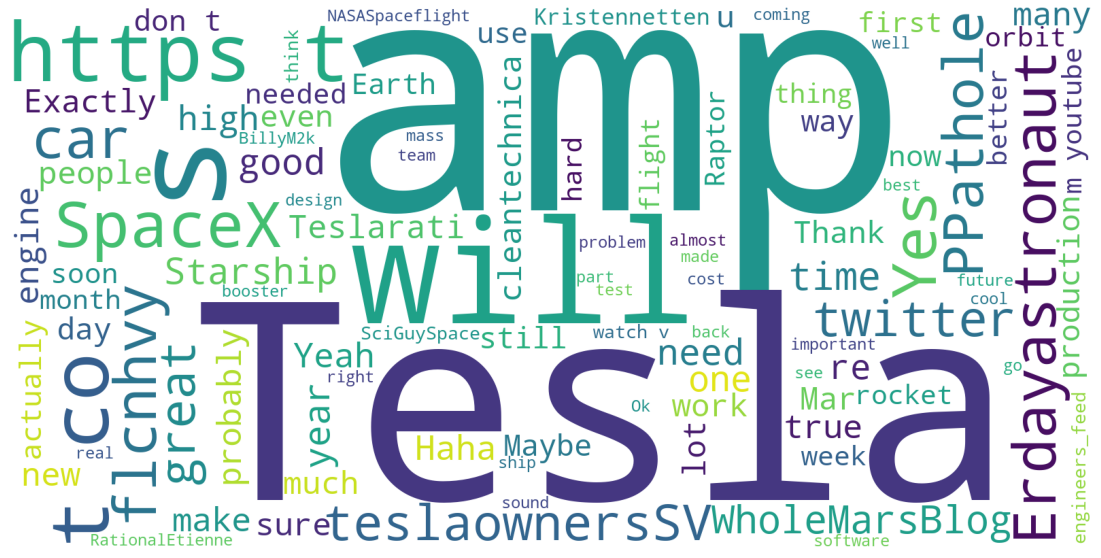

In [13]:
#generate a word cloud image of tweets
text = " ".join(tweet for tweet in df['renderedContent'])
wordcloud = WordCloud(width = 1600, height = 800, max_words=100, background_color="white").generate(text)

#display the generated image
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)
plt.axis("off")

We notice that https and youtube in the wordcloud, likely coming from the links and youtube vides. Probably best to get this removed from our tweets. I am also not sure what 'amp' is, so it might be worth taking a look at the tweets to understand from where this is getting pulled in the wordcloud

We can see some usernames and emojis in our 'renderedContent'. So, below we are doing some quick pre-processing to remove them before exploratory data analysis.

# Data preprocessing

In [14]:
#remove @username from tweet
def remove_username(tweet):
    return re.sub('@[^\s]+','',tweet)

#remove #hashtags from tweet
def remove_hashtag(tweet):
    return re.sub('#[^\s]+','',tweet)

#remove emojis from tweet
def remove_emoji(tweet):
    return emoji.replace_emoji(tweet, replace='')

#remove https from tweet
def remove_https(tweet):
    return re.sub('https[^\s]+','',tweet)

#remove youtube from tweet
def remove_youtube(tweet):
    return re.sub('m.youtube[^\s]+','',tweet)

#remove &amp; from tweet
def remove_amp(tweet):
    return re.sub('&amp;','',tweet)

#remove twitter.com links from tweet
def remove_twitter(tweet):
    return re.sub('[^\s]+.com[^\s]+','',tweet)

#remove space from tweet
def remove_space(tweet):
    return re.sub(' +', ' ', tweet)

#remove non-english characters from tweet
def remove_non_english(tweet):
    text = tweet.encode('ascii',errors='ignore')
    return text.decode('utf-8')

df['renderedContent'] = df['renderedContent'].apply(remove_username) #removing usernames
df['renderedContent'] = df['renderedContent'].apply(remove_hashtag) #removing hashtags
df['renderedContent'] = df['renderedContent'].apply(remove_emoji) #removing emojis
df['renderedContent'] = df['renderedContent'].apply(remove_non_english) #removing non english characters
df['renderedContent'] = df['renderedContent'].apply(remove_https) #removing https
df['renderedContent'] = df['renderedContent'].apply(remove_youtube) #removing youtube
df['renderedContent'] = df['renderedContent'].apply(remove_amp) #removing amp
df['renderedContent'] = df['renderedContent'].apply(remove_twitter) #removing twitter.com links
df['renderedContent'] = df['renderedContent'].apply(remove_space) #removing space
df['renderedContent'] = df['renderedContent'].replace(' ', np.nan) #replacing ' ' with np.nan
df['renderedContent'] = df['renderedContent'].replace('', np.nan) #replacing '' with np.nan
df = df.dropna(axis=0, subset=['renderedContent']) #dropping rows if any of the renderedContent has nan values
df = df.reset_index(drop=True)

(-0.5, 1599.5, 799.5, -0.5)

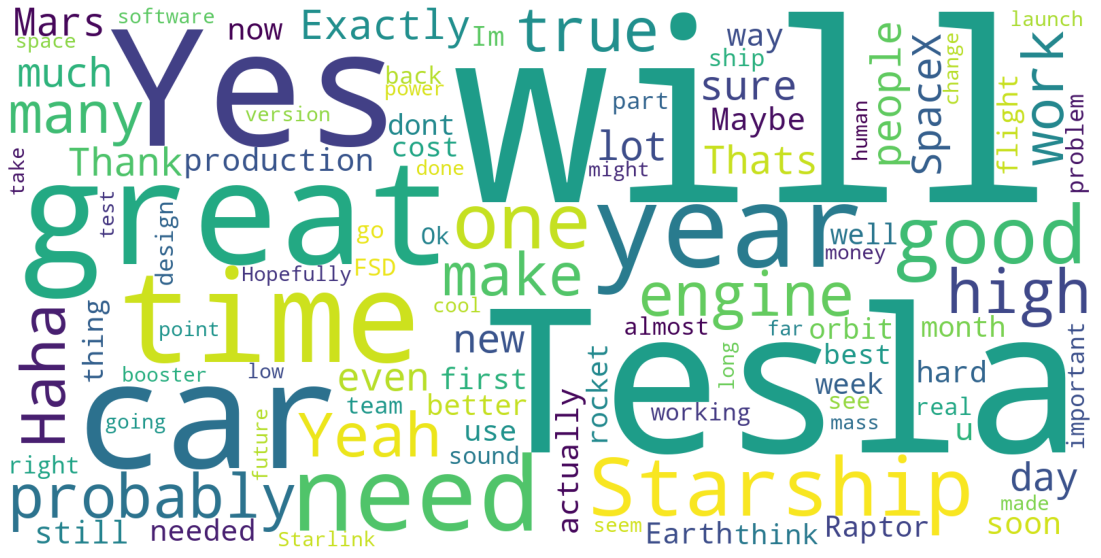

In [15]:
#rerun the wordcloud
text = " ".join(tweet for tweet in df['renderedContent'])
wordcloud = WordCloud(width = 1600, height = 800, max_words=100, background_color="white").generate(text)

#display the generated image
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)
plt.axis("off")

That is looking much better.

In [41]:
corpus = [tweet for tweet in df['renderedContent']]
len(corpus) #number of tweets after preprocessing

9257

Text(0, 0.5, 'Frequency')

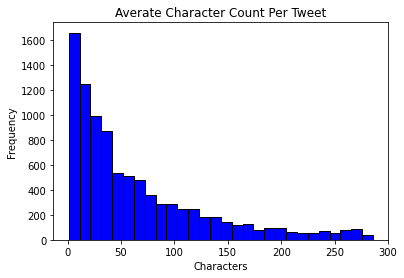

In [42]:
#understanding general trend in total character count per tweet
word_count = [len(tweet) for tweet in corpus]

# matplotlib histogram
plt.hist(word_count, color = 'blue', edgecolor = 'black',
         bins = int(280/10))

# Add labels
plt.title('Averate Character Count Per Tweet')
plt.xlabel('Characters')
plt.ylabel('Frequency')

Just to get a feel of the tweet sentiment. Lets do a quick sentiment analysis using VADER - which is an easy and ready to implement model that is particularly useful for understanding the sentiment of social media texts

Text(0, 0.5, 'Frequency')

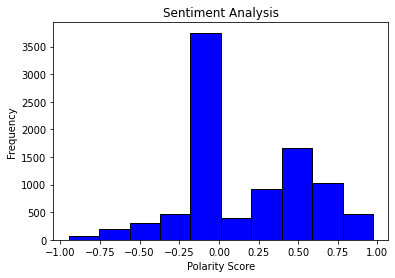

In [44]:
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

sentiment = [sid.polarity_scores(tweet)['compound'] for tweet in corpus]
# matplotlib histogram
plt.hist(sentiment, color = 'blue', edgecolor = 'black')
# Add labels
plt.title('Sentiment Analysis')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')

It seems much of Elon Musk's tweets are neutral in nature with a slight skew towards positive polarity

In [3]:
!pip install -q gpt-2-simple

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [4]:
import gpt_2_simple as gpt2

In [5]:
gpt2.download_gpt2(model_name="124M")

Fetching checkpoint: 1.05Mit [00:00, 544Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 2.62Mit/s]                                                   
Fetching hparams.json: 1.05Mit [00:00, 773Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [04:19, 1.92Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 629Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 4.33Mit/s]                                                
Fetching vocab.bpe: 1.05Mit [00:00, 4.45Mit/s]                                                      


In [50]:
file = open('tweet.txt', 'w')
file.write('\n'.join(corpus))
file.close()

In [8]:
sess = gpt2.start_tf_sess()

gpt2.finetune(sess,
              dataset='tweet.txt',
              model_name='124M',
              steps=1000,
              restore_from='fresh',
              run_name='run1',
              print_every=10,
              sample_every=500,
              save_every=100
              )

2022-03-19 10:58:11.405990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 10:58:11.551397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 10:58:11.551876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 10:58:15.386960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 10:58:15.387335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read f

Loading checkpoint models/124M/model.ckpt
INFO:tensorflow:Restoring parameters from models/124M/model.ckpt
Loading dataset...


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


dataset has 141007 tokens
Training...
[10 | 26.54] loss=4.40 avg=4.40
[20 | 46.13] loss=4.12 avg=4.26
[30 | 65.70] loss=4.13 avg=4.21
[40 | 85.23] loss=3.86 avg=4.12
[50 | 104.78] loss=3.68 avg=4.03
[60 | 124.33] loss=3.85 avg=4.00
[70 | 143.90] loss=3.67 avg=3.95
[80 | 163.45] loss=3.73 avg=3.93
[90 | 183.01] loss=3.43 avg=3.87
[100 | 202.57] loss=3.37 avg=3.82
Saving checkpoint/run1/model-100
[110 | 224.24] loss=3.23 avg=3.76
[120 | 243.78] loss=3.26 avg=3.72
[130 | 263.36] loss=3.21 avg=3.67
[140 | 282.92] loss=3.13 avg=3.63
[150 | 302.47] loss=3.06 avg=3.59
[160 | 322.03] loss=2.46 avg=3.52
[170 | 341.59] loss=2.51 avg=3.45
[180 | 361.16] loss=2.22 avg=3.38
[190 | 380.73] loss=2.50 avg=3.33
[200 | 400.28] loss=2.58 avg=3.29
Saving checkpoint/run1/model-200
Instructions for updating:
Use standard file APIs to delete files with this prefix.
[210 | 421.46] loss=1.87 avg=3.21
[220 | 441.04] loss=1.94 avg=3.15
[230 | 460.62] loss=1.81 avg=3.08
[240 | 480.20] loss=1.83 avg=3.02
[250 | 49

In [16]:
sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess, run_name='run1')

2022-03-20 06:12:09.898384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 06:12:10.026015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 06:12:10.026537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 06:12:12.430003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 06:12:12.430380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read f

Loading checkpoint checkpoint/run1/model-1000
INFO:tensorflow:Restoring parameters from checkpoint/run1/model-1000


In [52]:
gpt2_generated_tweet = gpt2.generate(sess,
              length=200,
              temperature=0.7,
              nsamples=1,
              batch_size=1,
              truncate = '<|endoftext|>',
              return_as_list=True
              )

gpt2_generated_tweet[0].split('\n')[0]

'Lengthy review of Tesla FSD software video release tomorrow (Friday)'